<a href="https://colab.research.google.com/github/federicotarozzi/Corso_AnalistaProgrammatoreDatiGeoSpaziali/blob/main/grafici%20per%20gestione%20di%20RESA%20pomodori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yield data preparation notebook

What yield data do we have? are they reliable?
In this notebook we explore the data provided by ISTAT looking for information on the production and cultivated area of industrial tomatoes in Italy. The information we have is production, that is defined at provincial basis. To correlate with other parameters, we use a bettere index that is yield (production/cultivated area), so the amout of cultivated area doesn't affect our studies.

Yield classes will then be constructed:

- 1: low yield (from 0 to 300 q/ha)
- 2: medium-low yield (from 300 to 600 q/ha)
- 3: medium-high yield (from 600 to 800 q/ha)
- 4: high yield (from 800 to 1200 q/ha)

You can find ISTAT data here: http://dati.istat.it/Index.aspx?QueryId=33703

#### Import the library we need

In [1]:
import pandas as pd # GESTISCE TABELLE
import seaborn as sns # GESTISCE GRAFICI
import matplotlib.pyplot as plt

#### Upload of the dataset from ISTAT

In [2]:
ita_yield = pd.read_csv('/content/POMODORI/ISTAT_tomato_yield_06_22_eng.csv', delimiter=',') #italian dataset

#show how the dataframe is
ita_yield.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITF41,Foggia,ART,total area - hectares,OFTP,tomatoes for processing,2006,2006,20000,NaN,NaN
1,ITF41,Foggia,ART,total area - hectares,OFTP,tomatoes for processing,2007,2007,23600,e,estimate data
2,ITF41,Foggia,ART,total area - hectares,OFTP,tomatoes for processing,2008,2008,19000,NaN,NaN
3,ITF41,Foggia,ART,total area - hectares,OFTP,tomatoes for processing,2009,2009,21000,NaN,NaN
4,ITF41,Foggia,ART,total area - hectares,OFTP,tomatoes for processing,2010,2010,21200,NaN,NaN


there are a lot of columns that are not needed and also the 'Data type' column it's not confortable to use

______________________________________________________________________________________________________________

#### Data preparation: tidyng and harmonization

In [3]:
#drop the coloumns that are not needed
ita_yield_clean = ita_yield.drop(['ITTER107', 'TIPO_DATO5', 'AGRI_MADRE', 'Type of crop', 'Select time', 'Flag Codes', 'Flags' ], axis = 1) # TOGLIAMO LE COLONNE CON IL DATAFRAME CHE NON CI INTERESSANO

In [4]:
#pivot df: transform 'Data type' in different columns and with the respective values
df_filtered = ita_yield_clean[ita_yield_clean['Data type'].isin(['total area - hectares', 'total production - quintals '])]
ita_df = df_filtered.pivot_table(index=['Territory', 'TIME'], columns='Data type', values='Value').reset_index()

In [5]:
# columns rename and translation: harmonization for other codes
ita_df.columns.name = None
ita_df = ita_df.rename(columns={'total area - hectares': 'tot_area_ha',
                                'total production - quintals ': 'tot_prod_q',
                                'Territory': 'Province',
                                'TIME': 'Year',
                                })
ita_df['Province'] = ita_df['Province'].str.replace("Reggio nell'Emilia", 'Reggio-Emilia')
ita_df['Province'] = ita_df['Province'].str.replace("Massa-Carrara", 'Massa')
ita_df['Province'] = ita_df['Province'].str.replace("Barletta-Andria-Trani", 'Barletta')
ita_df ['Yield']= ita_df['tot_prod_q']/ita_df['tot_area_ha'] # OPERAZIONE TRA COLONNE --> PRODOTTO/AREA

In [6]:
# Defining intervals for classes
classes_step = [0, 300, 600, 800, 1300]  # Limits of the intervals
# 'Class' column
ita_df['Class'] = pd.cut(ita_df['Yield'], bins=classes_step, labels=False, right=False).astype(int) + 1

In [8]:
ita_df # guarda che bella tabella che è venuta fuori.

,Province,Year,tot_area_ha,tot_prod_q,Yield,Class
0,Abruzzo,2006,1192,552250,463.296980,2
1,Abruzzo,2007,1139,517950,454.741001,2
2,Abruzzo,2008,1114,521450,468.087971,2
3,Abruzzo,2009,1098,513850,467.987250,2
4,Abruzzo,2010,1106,517550,467.947559,2
...,...,...,...,...,...,...
1675,Viterbo,2018,1600,1120000,700.000000,3
1676,Viterbo,2019,1600,1152000,720.000000,3
1677,Viterbo,2020,1600,1115000,696.875000,3
1678,Viterbo,2021,1600,1185000,740.625000,3


_______________________________________________________________________________________________________________

#### Data visualization


Study of yield values with histogram

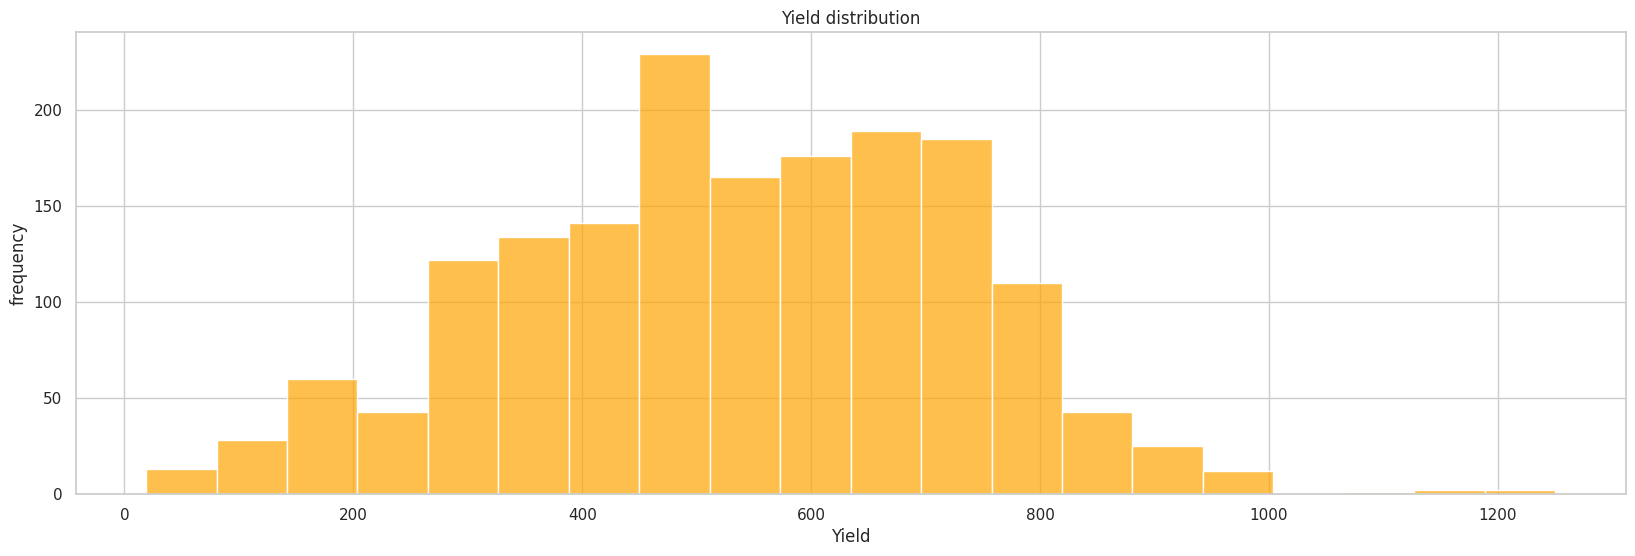

In [7]:
# Set seaborn style
sns.set(style="whitegrid")

# hist
plt.figure(figsize=(20, 6))
sns.histplot(ita_df['Yield'], bins=20, color='orange', edgecolor='white', alpha=0.7)

plt.title('Yield distribution')
plt.xlabel('Yield')
plt.ylabel('frequency')

plt.show()


Study of yield values by province

<AxesSubplot:xlabel='Yield', ylabel='Province'>

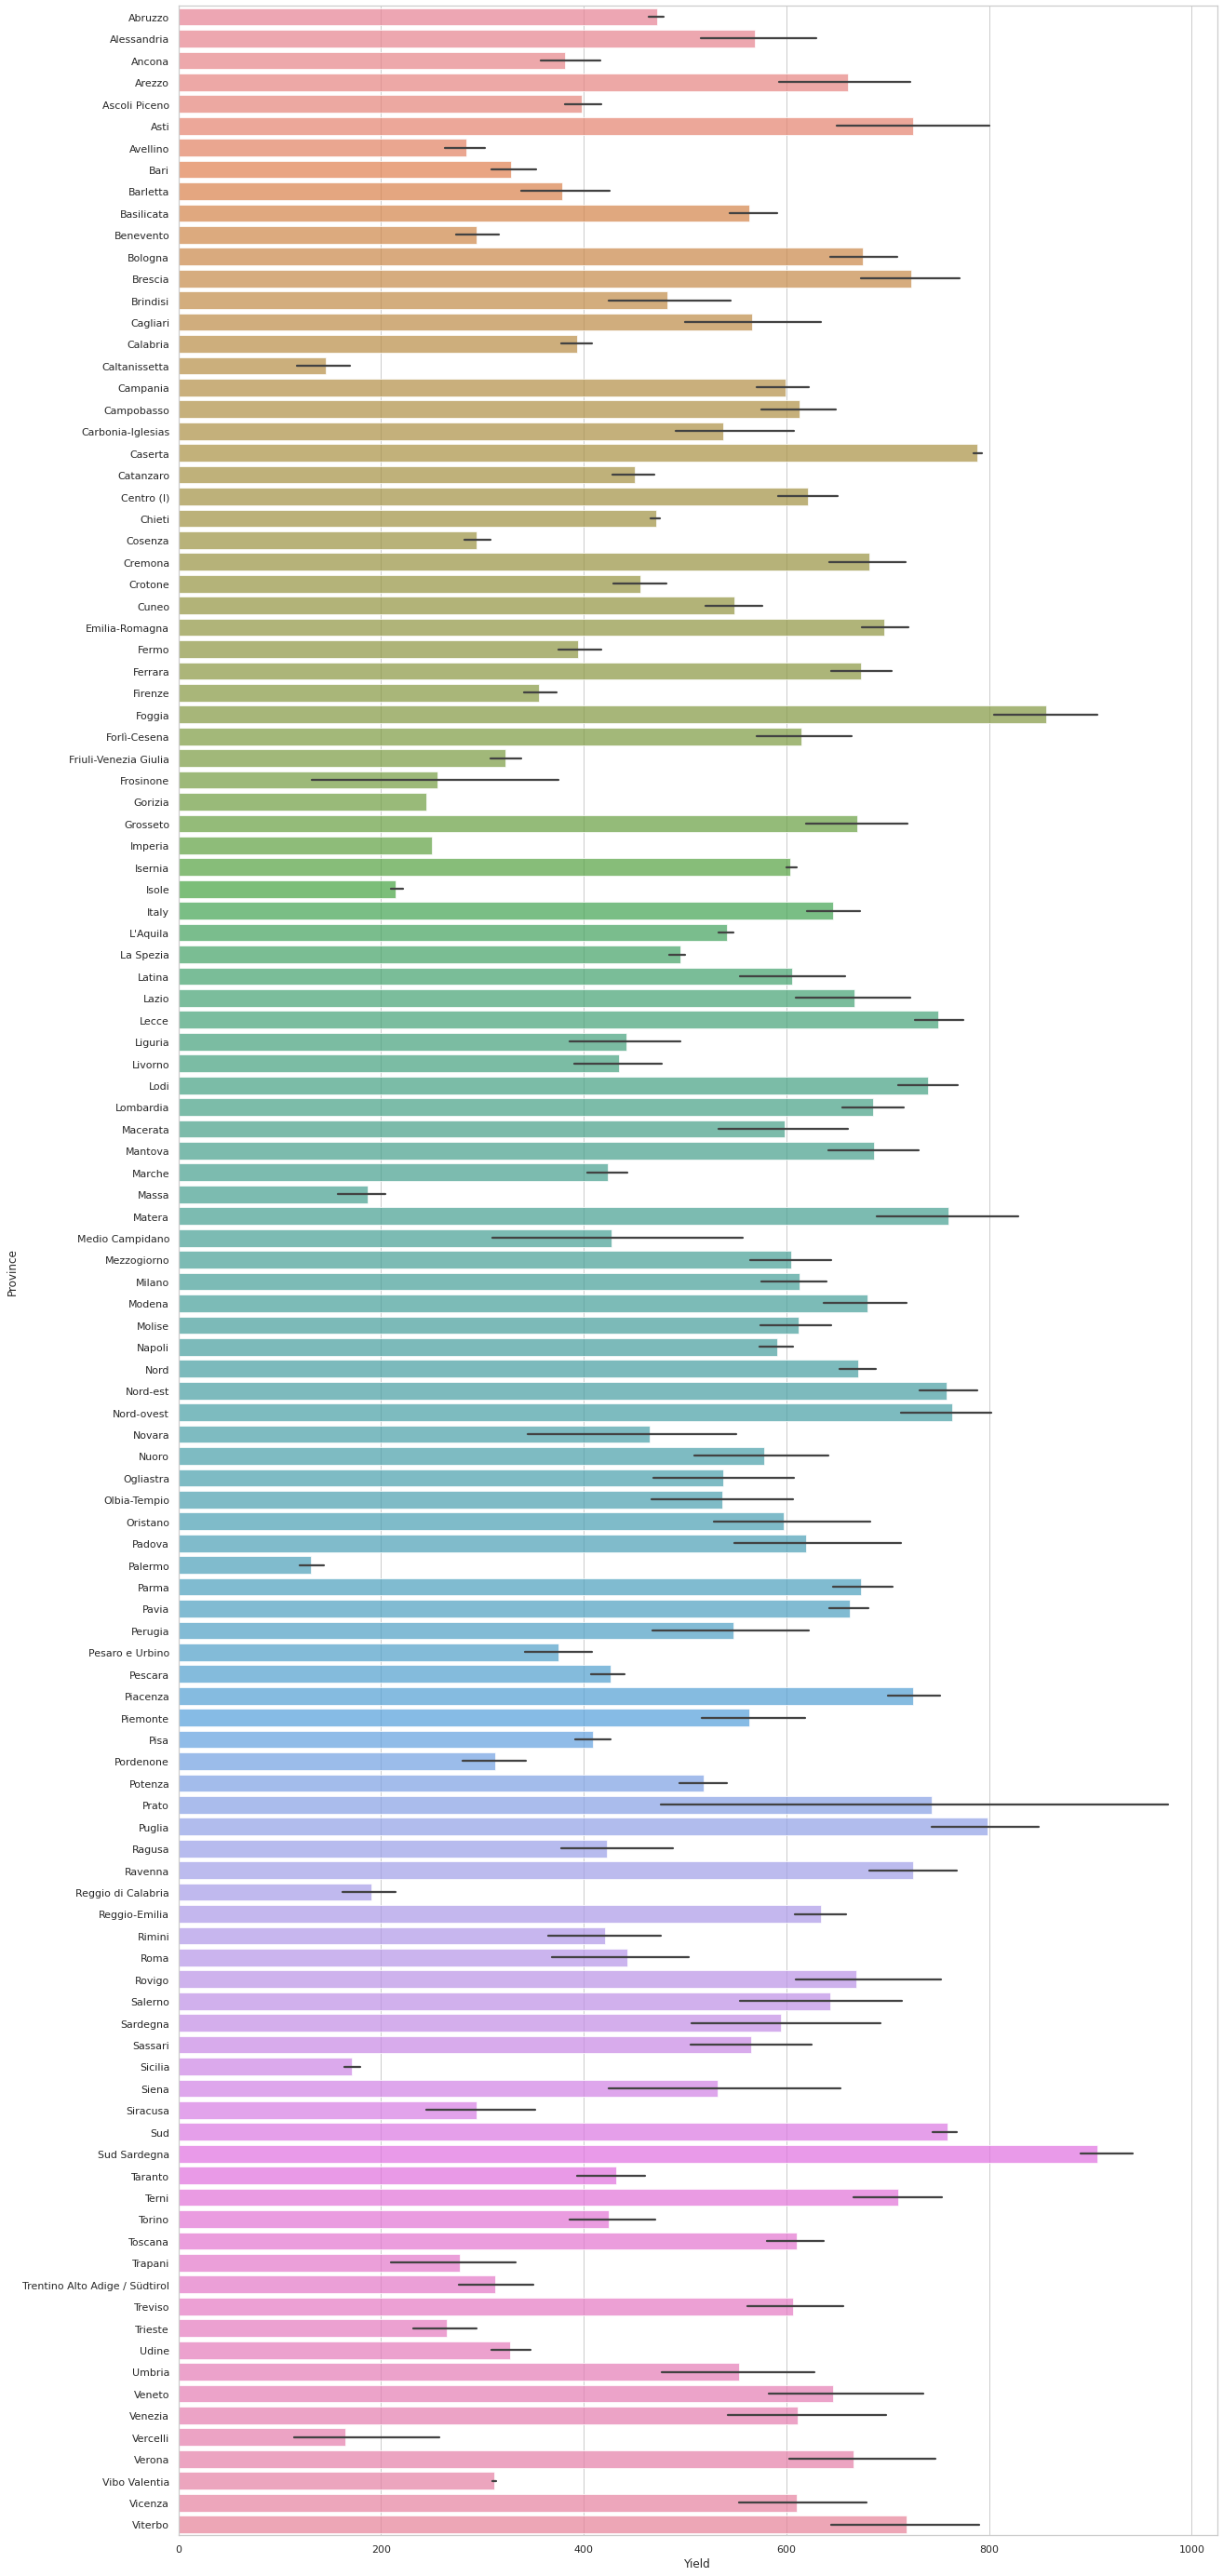

In [ ]:
plt.figure(figsize=(20, 50))
sns.barplot(ita_df, x="Yield", y="Province", hue = 'Province', alpha=0.7) # grafico con il pacchetto siborn che è bello per i grafici

Yield in Piacenza and Ravenna provinces

<Axes: xlabel='Province', ylabel='Yield'>

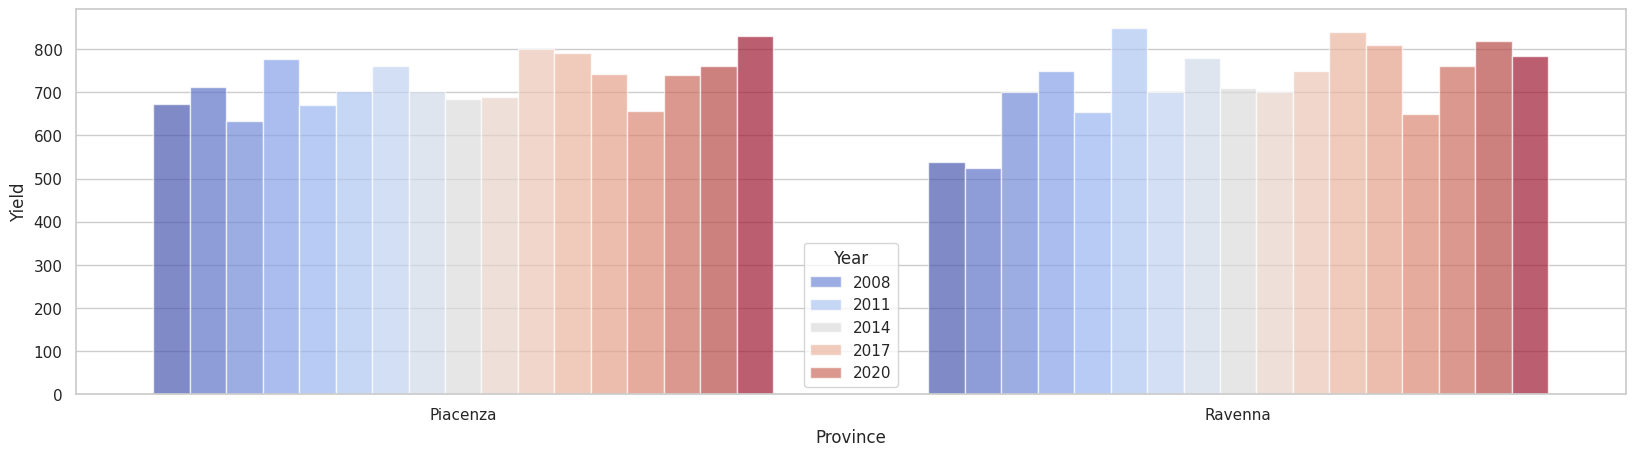

In [9]:
provinces = ita_df[ita_df['Province'].isin(['Piacenza', 'Ravenna'])]
plt.figure(figsize=(20, 5))
sns.barplot(provinces, x="Province", y="Yield", hue = 'Year', alpha=0.7 , palette="coolwarm")

______________________________________________________________________________________________________________________________

#### Save the dataset on csv

In [10]:
ita_df.to_csv('/content/POMODORI/yield_ita_data_def.csv', index=False) # salva i dato